## Import Libs

In [34]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=4)

## ML Utils Libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [45]:
class MachineLearningAnalyzer():
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.colors = [
            "blue",
            "orange",
            "green",
            "red",
            "purple",
            "brown",
            "pink",
            "gray",
            "olive",
            "cyan",
            "blue",
            "orange",
            "green",
            "red",
            "purple",
        ]
        self.__load_datasource()
        self.__plot_data()
        
    def perform_analysis(self):
        results = self.__train_and_predict()
        return results
    
    def __load_datasource(self):
        print("Loading datasource from %s" % (self.file_path))
        self.datasource = pd.read_csv(self.file_path, index_col = 0).sort_values(by=['time_frame'])
        print("Datasource loaded: len = %d" % (len(self.datasource)))
        self.entrypoints = [key for key in self.datasource.keys() if "ENTRYPOINT_N_INVOC_API" in key]
        print("Entrypoints size: %d" % (len(self.entrypoints)))
        print("Entrypoint list")
        pp.pprint(self.entrypoints)
        
    def __plot_data(self):
        titles = self.entrypoints
        feature_keys = self.entrypoints
        date_time_key = "time_frame"
        self.__show_raw_visualization(data = self.datasource, date_time_key = date_time_key, titles = titles, feature_keys = feature_keys, colors = self.colors)


    def __show_raw_visualization(self, data, titles, feature_keys, colors, date_time_key):
        time_data = data[date_time_key]
        fig, axes = plt.subplots(
            nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
        )
        for i in range(len(feature_keys)):
            key = feature_keys[i]
            # print(key)
            c = colors[i % (len(colors))]
            t_data = data[key]
            t_data.index = time_data
            t_data.head()
            ax = t_data.plot(
                ax=axes[i // 2, i % 2],
                color=c,
                title="{}".format(titles[i]),
                rot=25,
            )
            ax.legend([titles[i]])
        plt.tight_layout()
        plt.show()
        
    def __train_and_predict(self, limit_plot = 10):
        X_cols = [key for key in self.datasource.keys() if "ENDPOINT_N_INVOC_API" in key]
        y_cols = [key for key in self.datasource.keys() if "ENTRYPOINT_AVG_EXTIME" in key]
        
        
        #normalized_ds = (datasource-datasource.mean())/datasource.std()
        normalized_ds=(self.datasource-self.datasource.min())/(self.datasource.max()-self.datasource.min())
        print("Data normalized")
        
        X = normalized_ds[X_cols].copy()
        y = normalized_ds[y_cols].copy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1, shuffle=False)

        input_len = X_train.shape[1]
        output_len = y_train.shape[1]

        print("Input size", input_len, "Output size", output_len)
        
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.Input(shape=(input_len,)))
        self.model.add(tf.keras.layers.Dense(64))
        self.model.add(tf.keras.layers.Dense(32))
        self.model.add(tf.keras.layers.Dense(output_len))

        self.model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.1),
            loss='mean_squared_error')
        
        self.model.summary()
        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=20)
        
        X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=False)

        history = self.model.fit(X_train_val, y_train_val, validation_data=(X_test_val, y_test_val), callbacks=[es_callback], verbose = 1, epochs = 100)
        
        # summarize history for loss
        plt.plot(history.history['loss'], label="loss")
        plt.plot(history.history['val_loss'], label="validation_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        
        predictions = self.model.predict(X_test)
        
        results_dict = {}
        
        results_dict["TOTAL MSE"] = mean_squared_error(predictions, y_test.to_numpy())
        results_dict["TOTAL MAE"] = mean_absolute_error(predictions, y_test.to_numpy())
        
        print("TOTAL MSE: ", mean_squared_error(predictions, y_test.to_numpy()))
        print("TOTAL MAE: ", mean_absolute_error(predictions, y_test.to_numpy()))
        
        for idx in range(len(predictions[:limit_plot])):
            print("\n\n====== Prediction for %d ========" % (idx))
            plt.plot(predictions[idx], label="Prediction")
            plt.plot(y_test.to_numpy()[idx], label="Actual values")
            plt.legend()
            plt.show()
        
        transposed_preds = predictions.transpose()
        transposed_vals = y_test.to_numpy().transpose()

        for idx in range(len(transposed_preds)):
            print("\n\n========= FEATURE %d ANALYSIS (%s) ==========" % (idx, y_test.keys()[idx]))
            plt.plot(transposed_preds[idx], label="Prediction")
            plt.plot(transposed_vals[idx], label="Actual values")
            plt.legend()
            plt.show()
            print("MAE: ", mean_absolute_error(transposed_preds[idx], transposed_vals[idx]))
            print("MSE: ", mean_squared_error(transposed_preds[idx], transposed_vals[idx]))
            
            results_dict[y_test.keys()[idx] + " MAE"] = mean_absolute_error(transposed_preds[idx], transposed_vals[idx])
            results_dict[y_test.keys()[idx] + " MSE"] = mean_squared_error(transposed_preds[idx], transposed_vals[idx])
        
        return results_dict

In [46]:
results = {}

Loading datasource from avv_dataset_DT_500.csv
Datasource loaded: len = 2589
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-consign-service:findByOrderId',
    'ENTRYPOINT_N_INVOC_API_ts-consign-service:updateConsign',
    'ENTRYPOINT_N_INVOC_API_ts-travel-plan-service:getByCheapest',
    'ENTRYPOINT_N_INVOC_API_ts-preserve-service:preserve',
    'ENTRYPOINT_N_INVOC_API_ts-contacts-service:findContactsByAccountId',
    'ENTRYPOINT_N_INVOC_API_ts-food-service:getAllFood',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:queryOrdersForRefresh',
    'ENTRYPOINT_N_INVOC_API_ts-cancel-service:cancelTicket',
    'ENTRYPOINT_N_INVOC_API_ts-inside-payment-service:pay',
    'ENTRYPOINT_N_INVOC_API_ts-auth-service:getToken',
    'ENTRYPOINT_N_INVOC_API_ts-travel-service:queryInfo',
    'ENTRYPOINT_N_INVOC_API_ts-assurance-service:getAllAssuranceType',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:POST']


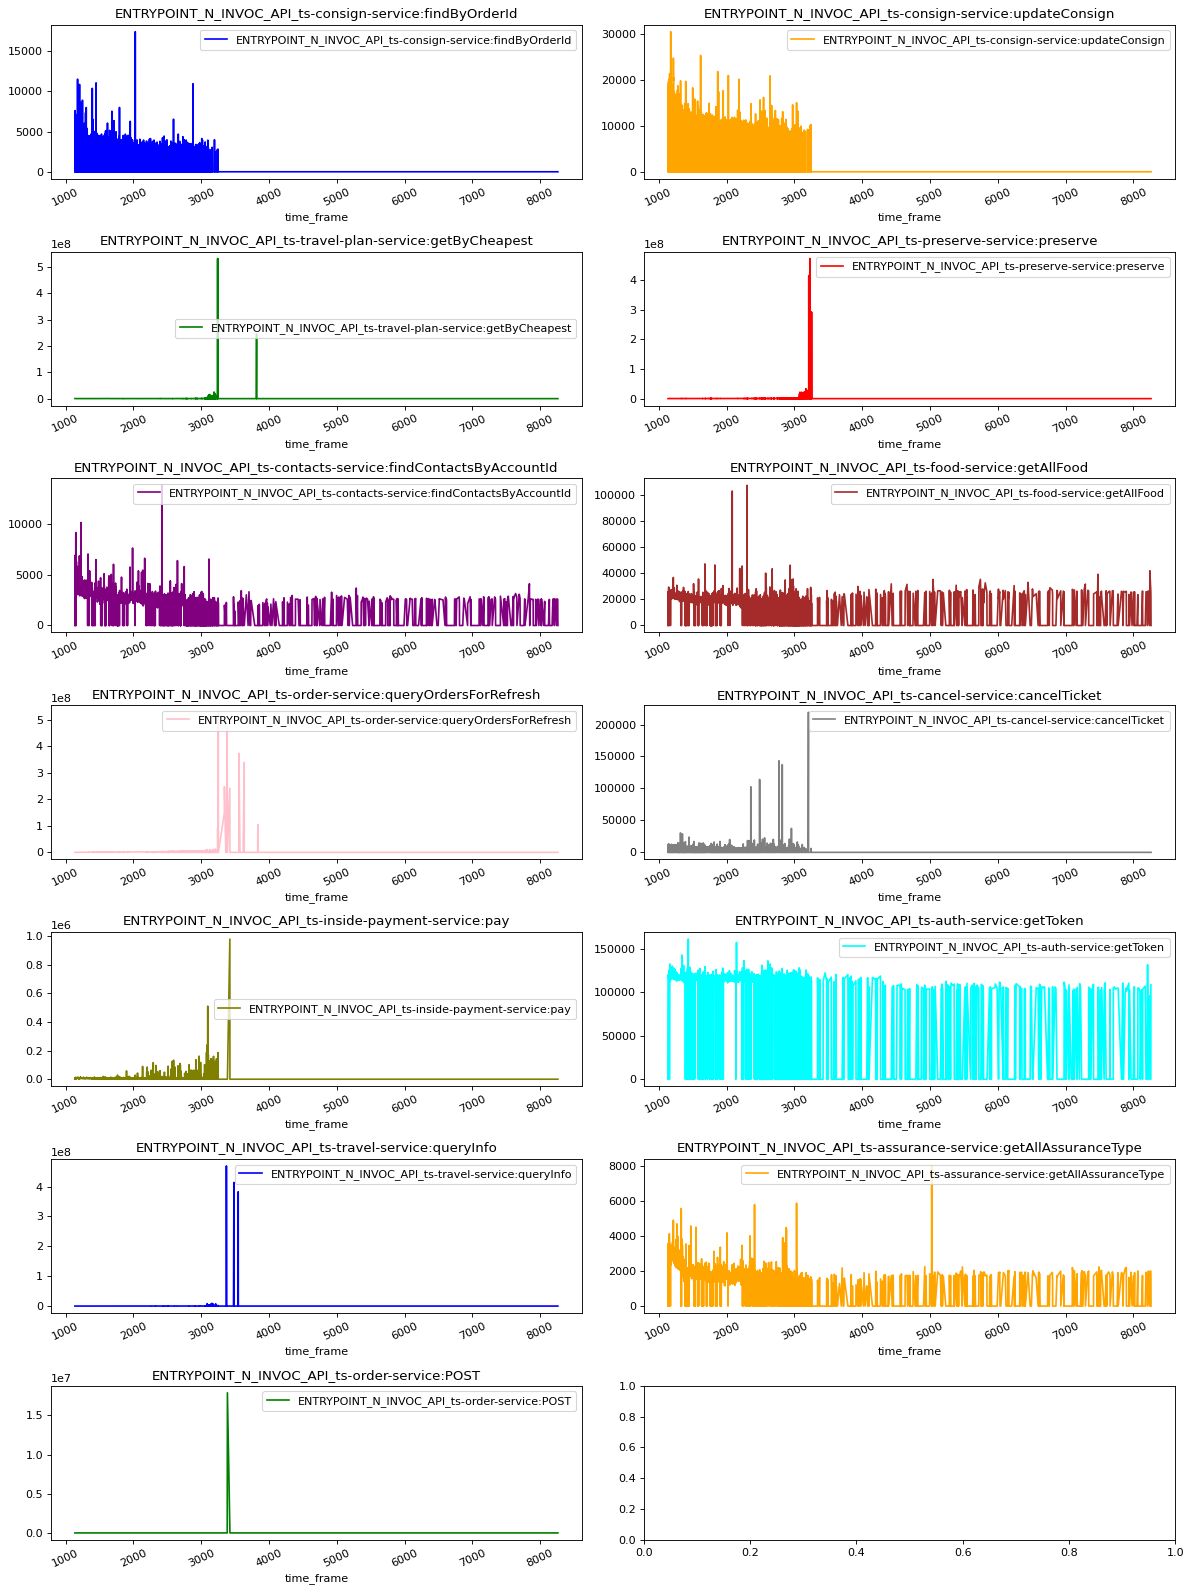

Data normalized
Input size 32 Output size 13
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 13)                429       
                                                                 
Total params: 4,621
Trainable params: 4,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
44/44 [==============================] - 1s 10ms/step - loss: 23.8947 - val_loss: 0.1140
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 0.1035 - val_loss: 0.0183
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss

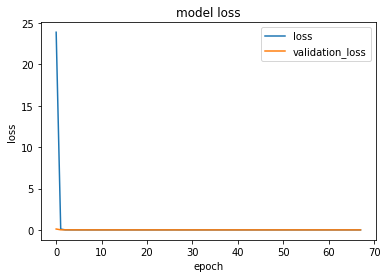

27/27 [==============================] - 0s 995us/step
TOTAL MSE:  0.01966576934443653
TOTAL MAE:  0.06549848091274557


====== Prediction for 0 ========


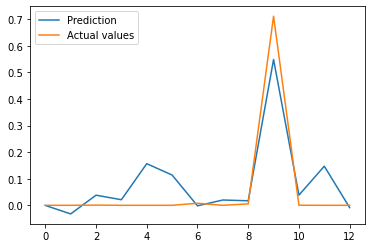



====== Prediction for 1 ========


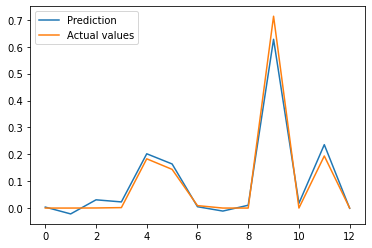



====== Prediction for 2 ========


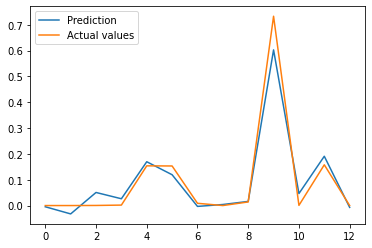



====== Prediction for 3 ========


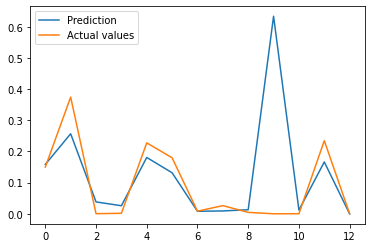



====== Prediction for 4 ========


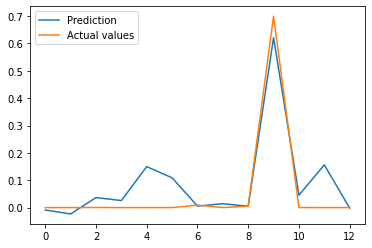



====== Prediction for 5 ========


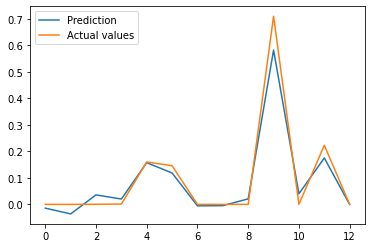



====== Prediction for 6 ========


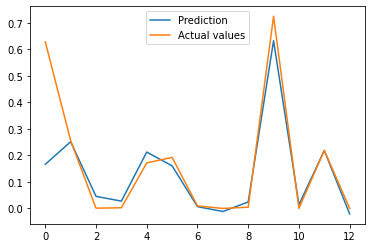



====== Prediction for 7 ========


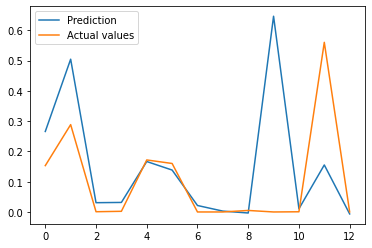



====== Prediction for 8 ========


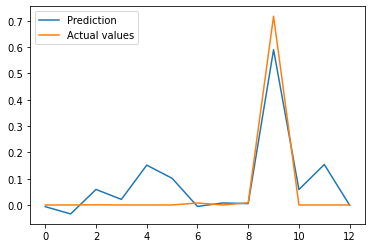



====== Prediction for 9 ========


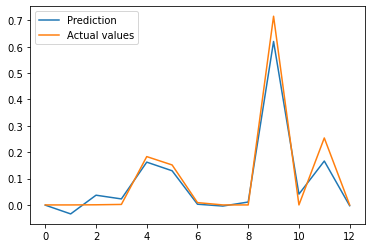



========= FEATURE 0 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId) ==========


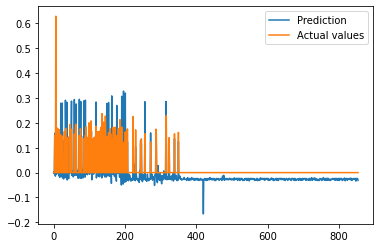

MAE:  0.028122105805168874
MSE:  0.0014825297773791257


========= FEATURE 1 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign) ==========


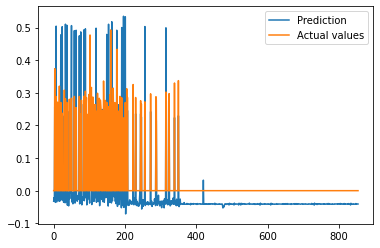

MAE:  0.04384739874970224
MSE:  0.0031519903160383026


========= FEATURE 2 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest) ==========


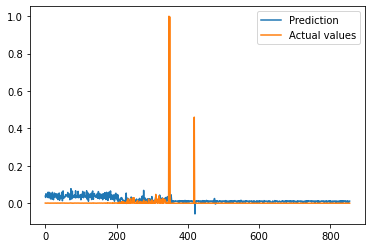

MAE:  0.019979889563288892
MSE:  0.002990444142242595


========= FEATURE 3 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve) ==========


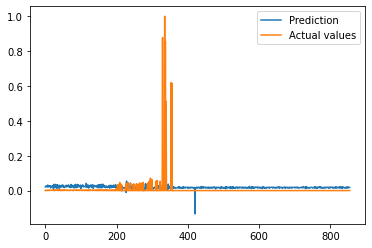

MAE:  0.023588541462337645
MSE:  0.004258443994113936


========= FEATURE 4 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId) ==========


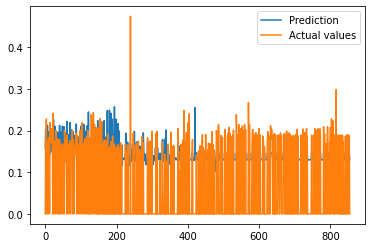

MAE:  0.09376555828615186
MSE:  0.011404147269694768


========= FEATURE 5 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood) ==========


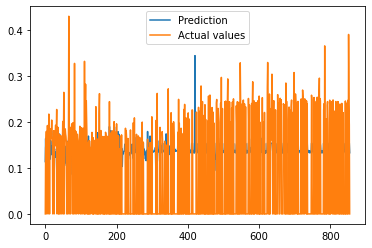

MAE:  0.10240587371562296
MSE:  0.012604622634590666


========= FEATURE 6 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh) ==========


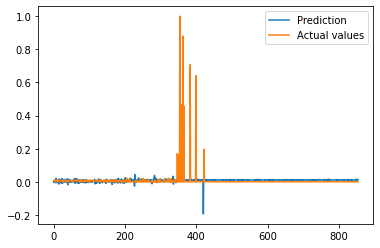

MAE:  0.015752434441893903
MSE:  0.003892548645947612


========= FEATURE 7 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket) ==========


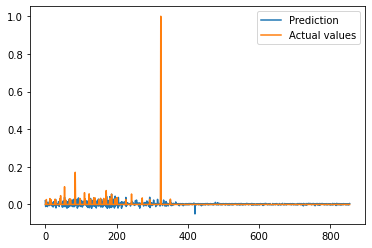

MAE:  0.006898377859670891
MSE:  0.0012315396308084582


========= FEATURE 8 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay) ==========


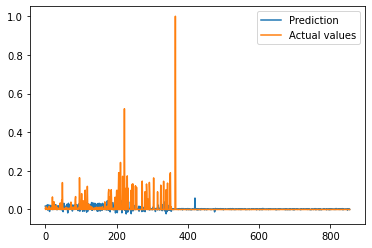

MAE:  0.012784440684992576
MSE:  0.0022703221710383263


========= FEATURE 9 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken) ==========


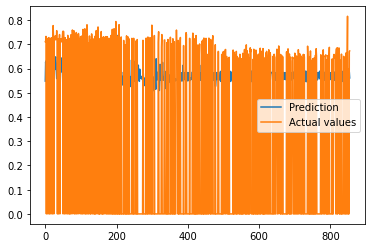

MAE:  0.377245731998729
MSE:  0.19577801980876988


========= FEATURE 10 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo) ==========


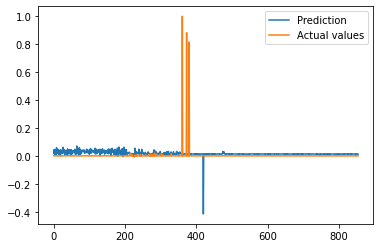

MAE:  0.02147969870425012
MSE:  0.003422769463132879


========= FEATURE 11 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType) ==========


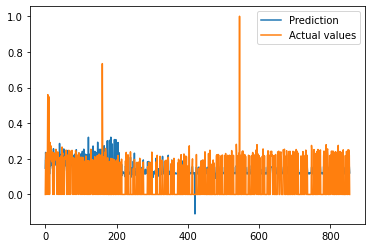

MAE:  0.09592829917102598
MSE:  0.011880990417696257


========= FEATURE 12 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-order-service:POST) ==========


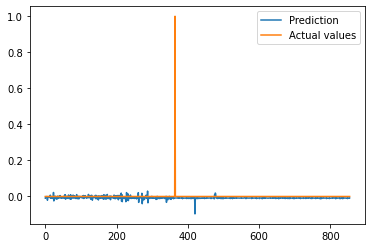

MAE:  0.00968190142285754
MSE:  0.0012866332062228588


In [47]:
results["avv_dataset_DT_500.csv"] = MachineLearningAnalyzer("avv_dataset_DT_500.csv").perform_analysis()

Loading datasource from avv_dataset_DT_100.csv
Datasource loaded: len = 10861
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-consign-service:findByOrderId',
    'ENTRYPOINT_N_INVOC_API_ts-travel-plan-service:getByCheapest',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:queryOrdersForRefresh',
    'ENTRYPOINT_N_INVOC_API_ts-inside-payment-service:pay',
    'ENTRYPOINT_N_INVOC_API_ts-preserve-service:preserve',
    'ENTRYPOINT_N_INVOC_API_ts-contacts-service:findContactsByAccountId',
    'ENTRYPOINT_N_INVOC_API_ts-consign-service:updateConsign',
    'ENTRYPOINT_N_INVOC_API_ts-food-service:getAllFood',
    'ENTRYPOINT_N_INVOC_API_ts-cancel-service:cancelTicket',
    'ENTRYPOINT_N_INVOC_API_ts-auth-service:getToken',
    'ENTRYPOINT_N_INVOC_API_ts-assurance-service:getAllAssuranceType',
    'ENTRYPOINT_N_INVOC_API_ts-travel-service:queryInfo',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:POST']


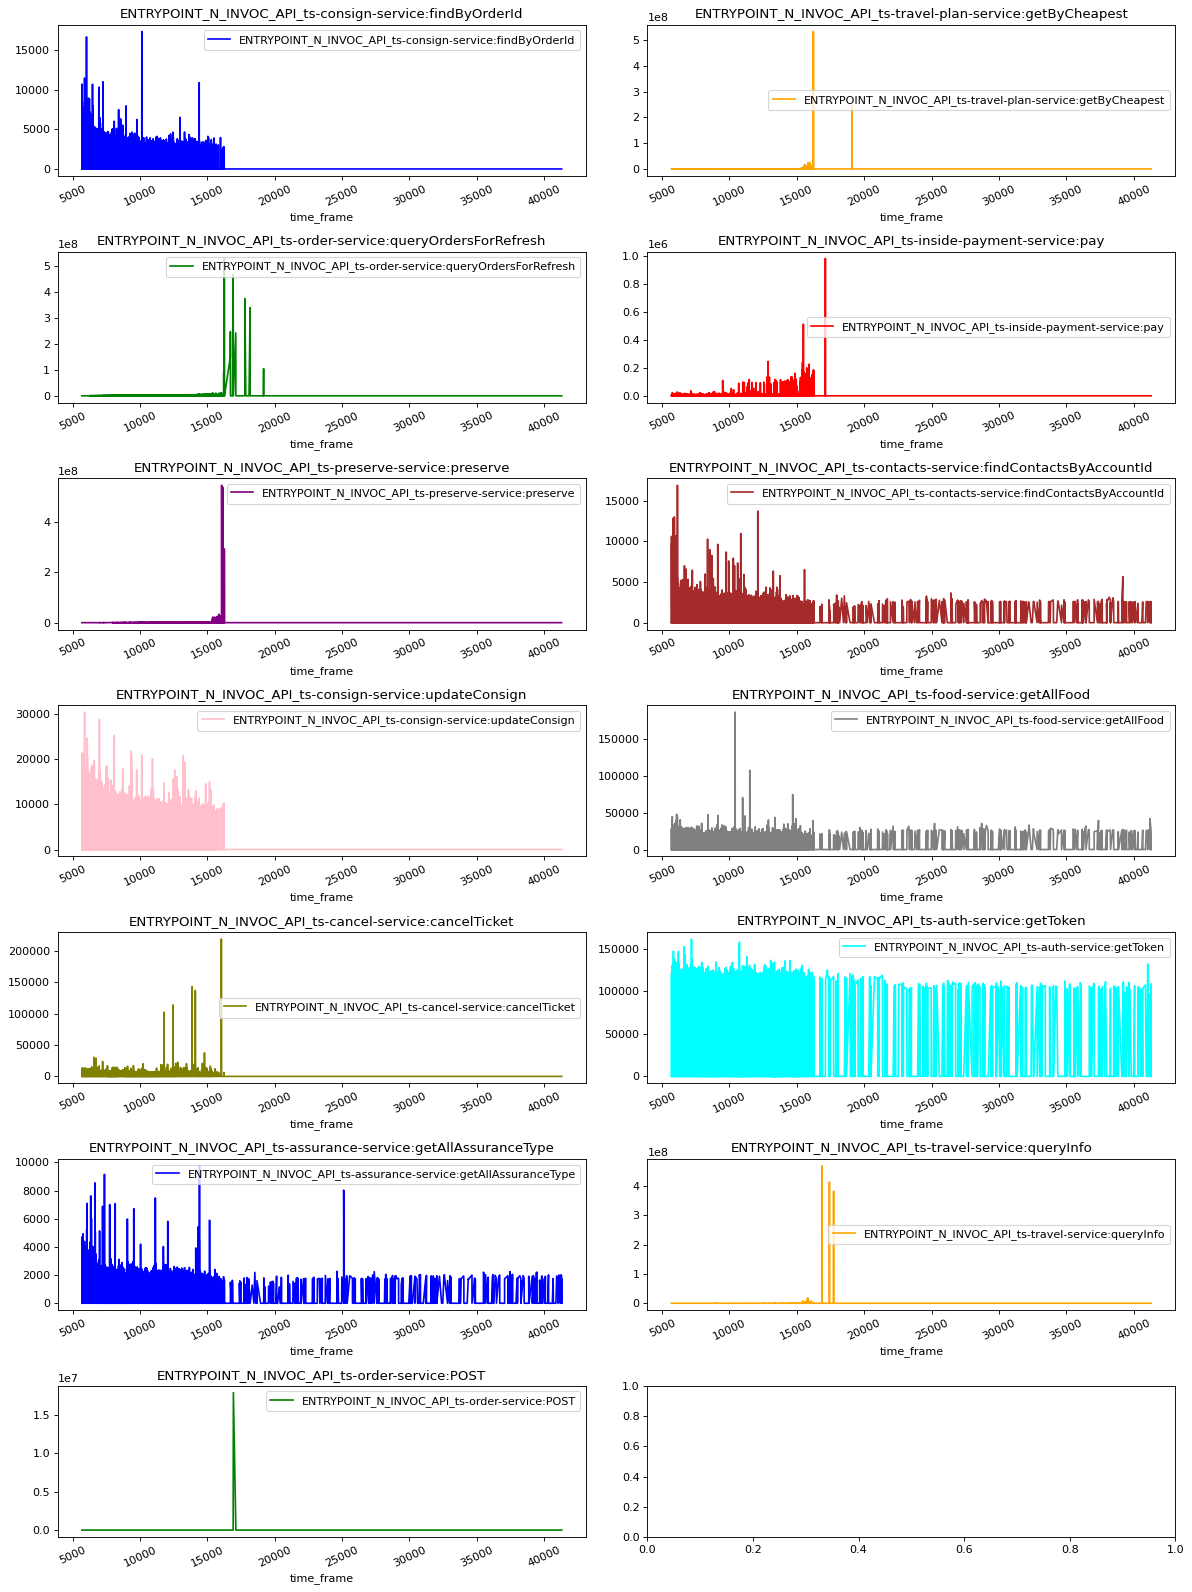

Data normalized
Input size 32 Output size 13
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 13)                429       
                                                                 
Total params: 4,621
Trainable params: 4,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
182/182 [==============================] - 1s 3ms/step - loss: 1.0978 - val_loss: 0.0119
Epoch 2/100
182/182 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 3/100
182/182 [==============================] - 0s 2ms/step - 

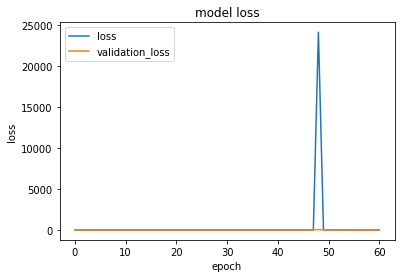

113/113 [==============================] - 0s 1ms/step
TOTAL MSE:  0.12461066131013068
TOTAL MAE:  0.25465945175355587


====== Prediction for 0 ========


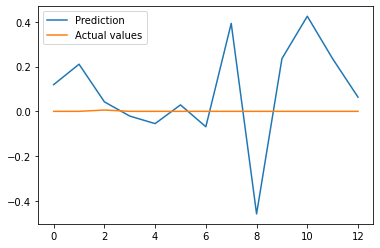



====== Prediction for 1 ========


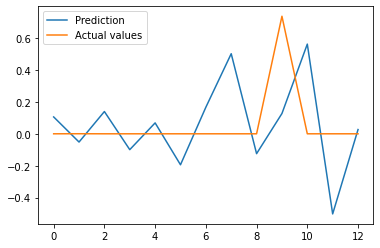



====== Prediction for 2 ========


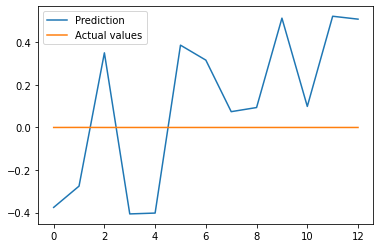



====== Prediction for 3 ========


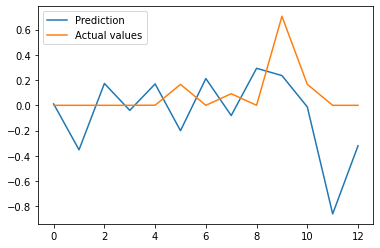



====== Prediction for 4 ========


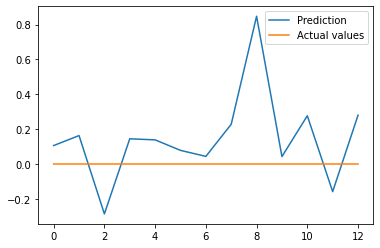



====== Prediction for 5 ========


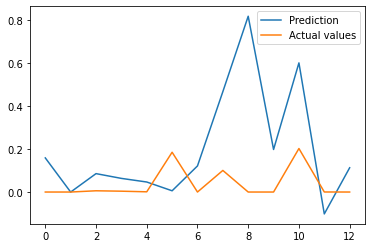



====== Prediction for 6 ========


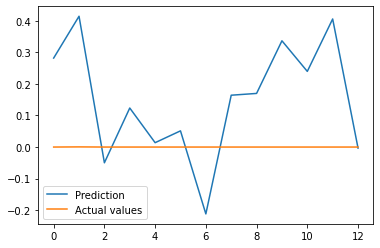



====== Prediction for 7 ========


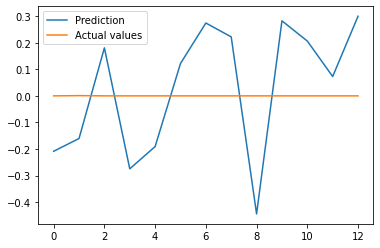



====== Prediction for 8 ========


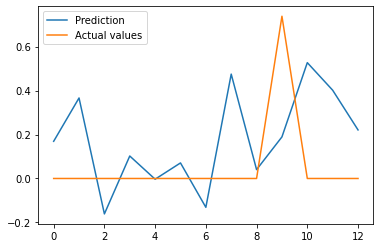



====== Prediction for 9 ========


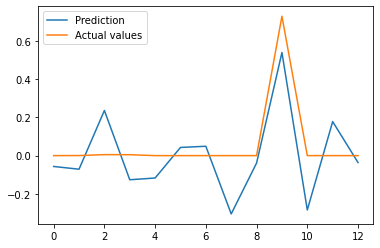



========= FEATURE 0 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId) ==========


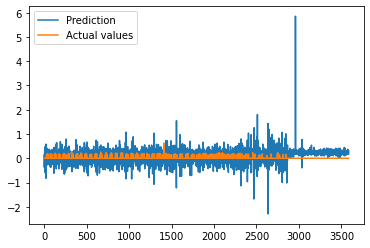

MAE:  0.20575212715676774
MSE:  0.07833834582281167


========= FEATURE 1 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest) ==========


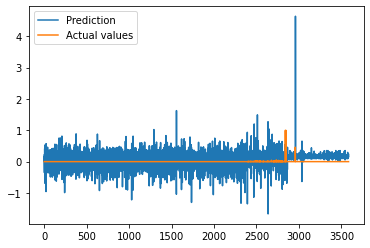

MAE:  0.20369028595185157
MSE:  0.07513203368960043


========= FEATURE 2 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh) ==========


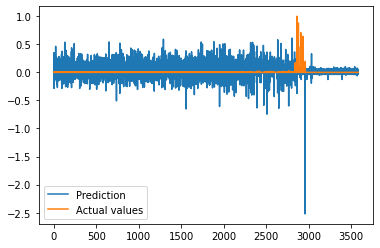

MAE:  0.10732061234845275
MSE:  0.02282728639717959


========= FEATURE 3 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay) ==========


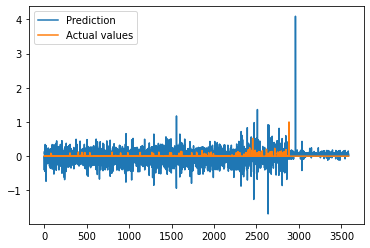

MAE:  0.12883019054043288
MSE:  0.03877155307228453


========= FEATURE 4 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve) ==========


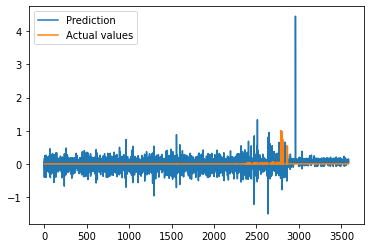

MAE:  0.11887526094653246
MSE:  0.03359943898605035


========= FEATURE 5 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId) ==========


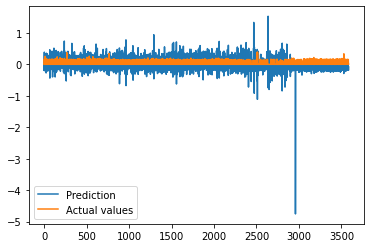

MAE:  0.1451423862115398
MSE:  0.04173447422049162


========= FEATURE 6 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign) ==========


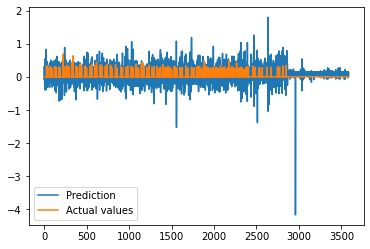

MAE:  0.18158961982595495
MSE:  0.0599561298876887


========= FEATURE 7 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood) ==========


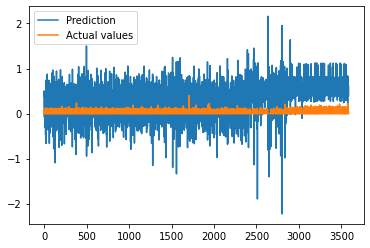

MAE:  0.40430775065055535
MSE:  0.2218171420603057


========= FEATURE 8 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket) ==========


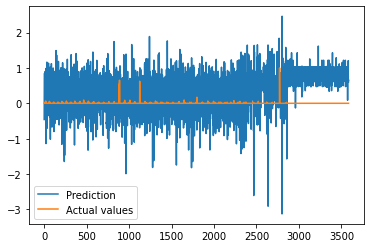

MAE:  0.5189726109846559
MSE:  0.37393751356180854


========= FEATURE 9 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken) ==========


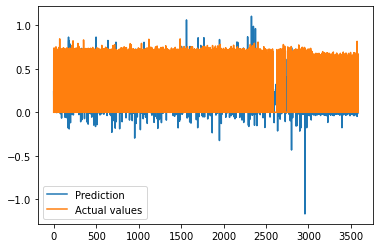

MAE:  0.2794699523256138
MSE:  0.11319994115927268


========= FEATURE 10 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType) ==========


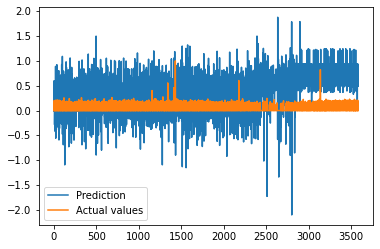

MAE:  0.4480108398981726
MSE:  0.2668298350501319


========= FEATURE 11 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo) ==========


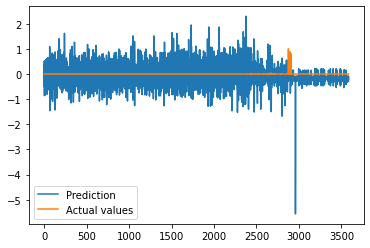

MAE:  0.3077188270606703
MSE:  0.17538929987998253


========= FEATURE 12 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-order-service:POST) ==========


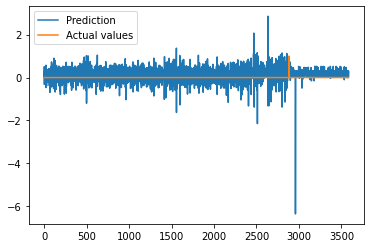

MAE:  0.260892408895027
MSE:  0.1184056032441022


In [48]:
results["avv_dataset_DT_100.csv"] = MachineLearningAnalyzer("avv_dataset_DT_100.csv").perform_analysis()

Loading datasource from avv_dataset_DT_1000.csv
Datasource loaded: len = 1497
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-consign-service:findByOrderId',
    'ENTRYPOINT_N_INVOC_API_ts-consign-service:updateConsign',
    'ENTRYPOINT_N_INVOC_API_ts-travel-plan-service:getByCheapest',
    'ENTRYPOINT_N_INVOC_API_ts-preserve-service:preserve',
    'ENTRYPOINT_N_INVOC_API_ts-contacts-service:findContactsByAccountId',
    'ENTRYPOINT_N_INVOC_API_ts-food-service:getAllFood',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:queryOrdersForRefresh',
    'ENTRYPOINT_N_INVOC_API_ts-cancel-service:cancelTicket',
    'ENTRYPOINT_N_INVOC_API_ts-inside-payment-service:pay',
    'ENTRYPOINT_N_INVOC_API_ts-travel-service:queryInfo',
    'ENTRYPOINT_N_INVOC_API_ts-assurance-service:getAllAssuranceType',
    'ENTRYPOINT_N_INVOC_API_ts-auth-service:getToken',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:POST']


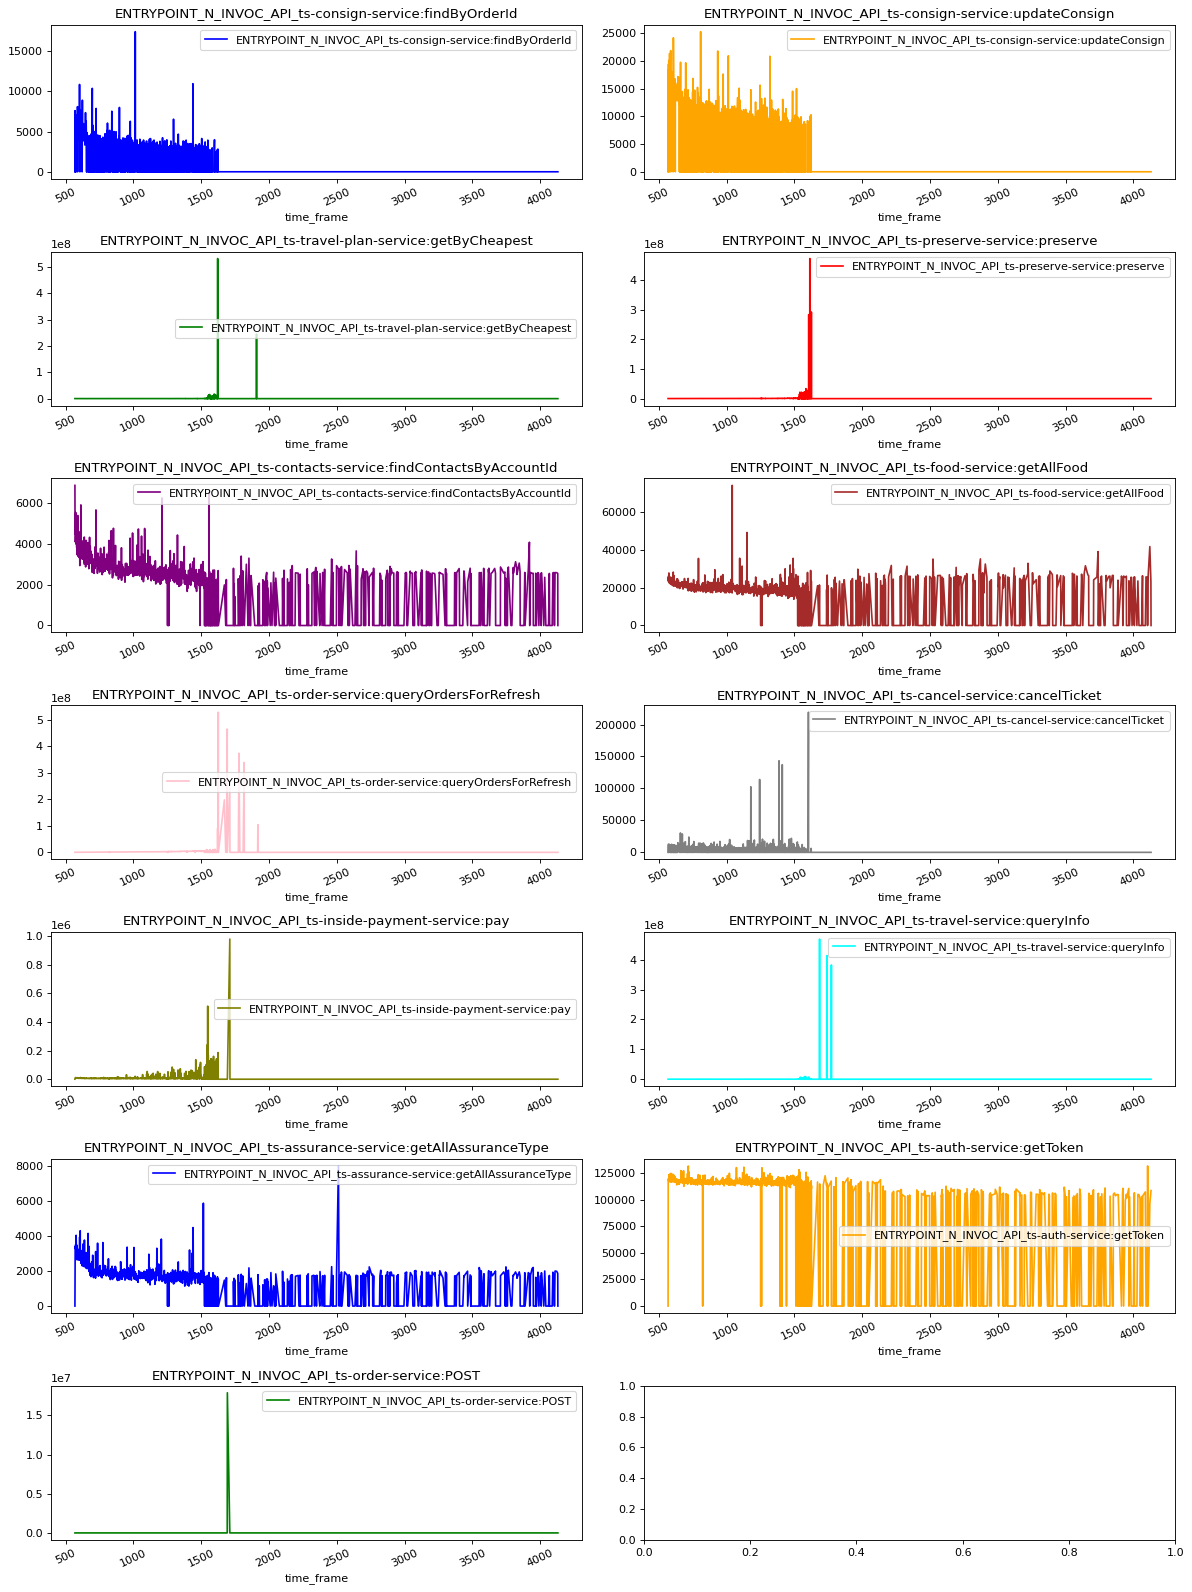

Data normalized
Input size 32 Output size 13
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 13)                429       
                                                                 
Total params: 4,621
Trainable params: 4,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
26/26 [==============================] - 1s 8ms/step - loss: 28.1180 - val_loss: 8.6840
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 2.9272 - val_loss: 0.5928
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss:

26/26 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0141
Epoch 75/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0143
Epoch 76/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0135
Epoch 77/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0140
Epoch 78/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0139
Epoch 79/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0153
Epoch 80/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0132
Epoch 81/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0128
Epoch 82/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0136
Epoch 83/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0142
Epoch 84/100


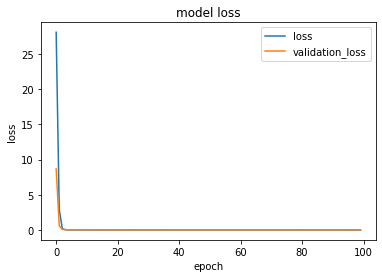

16/16 [==============================] - 0s 1ms/step
TOTAL MSE:  0.039275269463677494
TOTAL MAE:  0.09138326898174273


====== Prediction for 0 ========


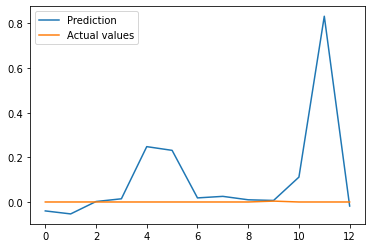



====== Prediction for 1 ========


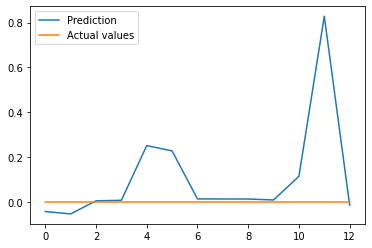



====== Prediction for 2 ========


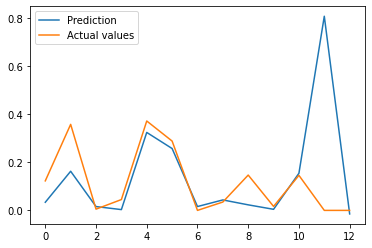



====== Prediction for 3 ========


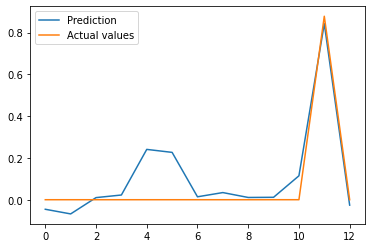



====== Prediction for 4 ========


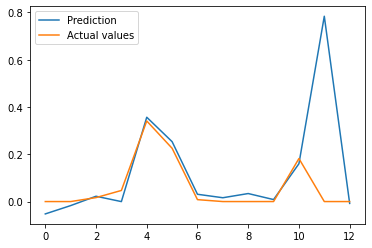



====== Prediction for 5 ========


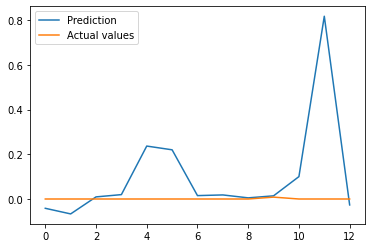



====== Prediction for 6 ========


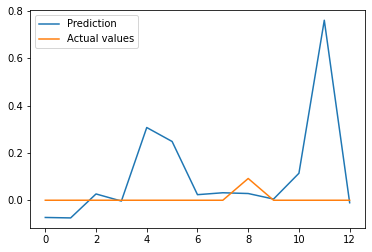



====== Prediction for 7 ========


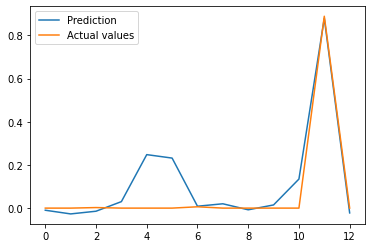



====== Prediction for 8 ========


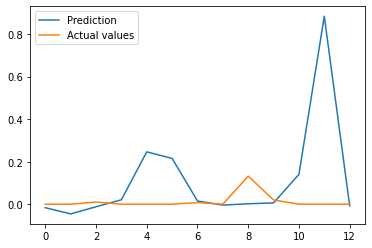



====== Prediction for 9 ========


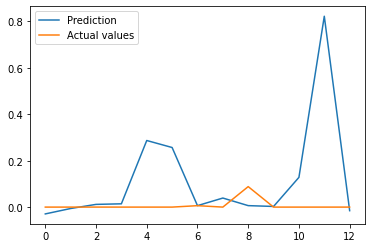



========= FEATURE 0 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId) ==========


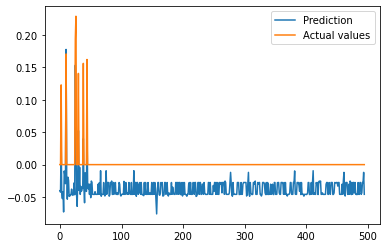

MAE:  0.03860566617973703
MSE:  0.0016609245362219668


========= FEATURE 1 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign) ==========


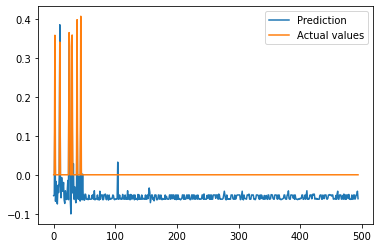

MAE:  0.05794925958079164
MSE:  0.003703516973333955


========= FEATURE 2 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest) ==========


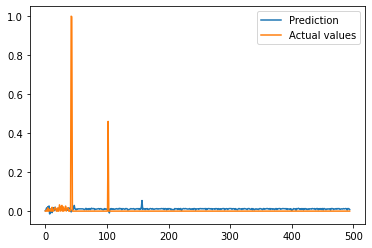

MAE:  0.016030394647598527
MSE:  0.004577977168575243


========= FEATURE 3 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve) ==========


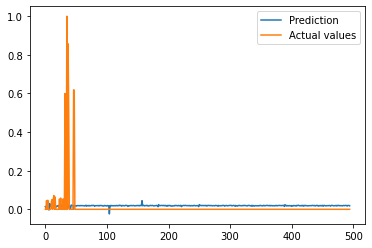

MAE:  0.027451918952659252
MSE:  0.006437000152632434


========= FEATURE 4 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId) ==========


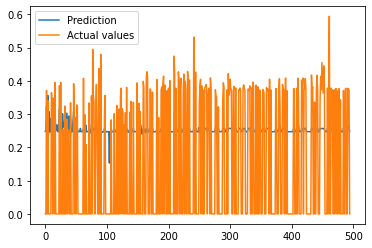

MAE:  0.19265802010917177
MSE:  0.04241595104165611


========= FEATURE 5 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood) ==========


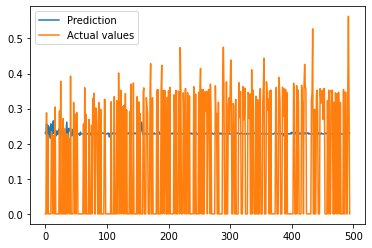

MAE:  0.1770023750012002
MSE:  0.03619379575778543


========= FEATURE 6 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh) ==========


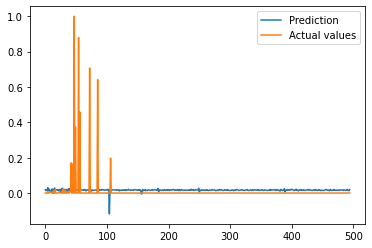

MAE:  0.025308390442133656
MSE:  0.006330048997890936


========= FEATURE 7 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket) ==========


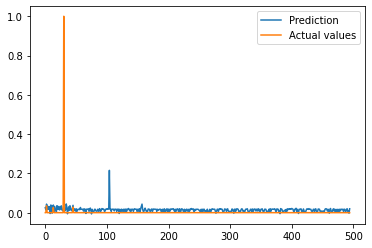

MAE:  0.016264588420356146
MSE:  0.002190687664769678


========= FEATURE 8 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay) ==========


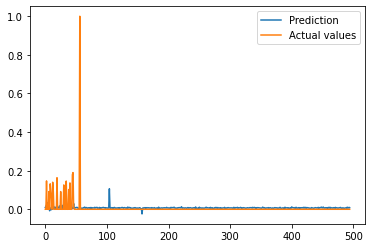

MAE:  0.012867889106043815
MSE:  0.0025299523885122955


========= FEATURE 9 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo) ==========


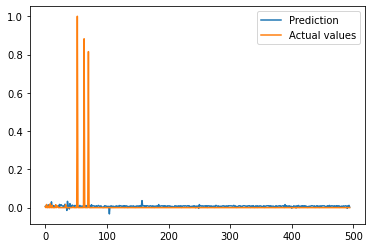

MAE:  0.01291576251244101
MSE:  0.00496940374755716


========= FEATURE 10 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType) ==========


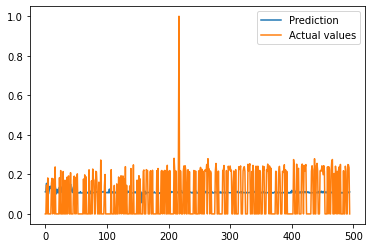

MAE:  0.10939652968497601
MSE:  0.013648810632499469


========= FEATURE 11 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken) ==========


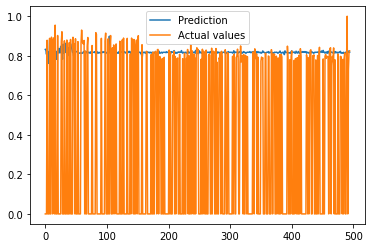

MAE:  0.4808123847411064
MSE:  0.3834469031545298


========= FEATURE 12 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-order-service:POST) ==========


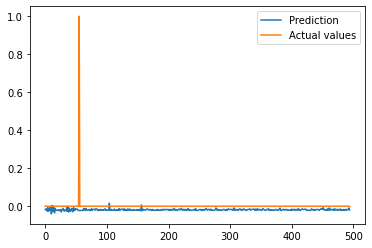

MAE:  0.02071931738444049
MSE:  0.002473530811843651


In [49]:
results["avv_dataset_DT_1000.csv"] = MachineLearningAnalyzer("avv_dataset_DT_1000.csv").perform_analysis()

Loading datasource from avv_dataset_DT_50.csv
Datasource loaded: len = 20708
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-travel-plan-service:getByCheapest',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:queryOrdersForRefresh',
    'ENTRYPOINT_N_INVOC_API_ts-consign-service:findByOrderId',
    'ENTRYPOINT_N_INVOC_API_ts-inside-payment-service:pay',
    'ENTRYPOINT_N_INVOC_API_ts-consign-service:updateConsign',
    'ENTRYPOINT_N_INVOC_API_ts-preserve-service:preserve',
    'ENTRYPOINT_N_INVOC_API_ts-food-service:getAllFood',
    'ENTRYPOINT_N_INVOC_API_ts-contacts-service:findContactsByAccountId',
    'ENTRYPOINT_N_INVOC_API_ts-cancel-service:cancelTicket',
    'ENTRYPOINT_N_INVOC_API_ts-auth-service:getToken',
    'ENTRYPOINT_N_INVOC_API_ts-assurance-service:getAllAssuranceType',
    'ENTRYPOINT_N_INVOC_API_ts-travel-service:queryInfo',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:POST']


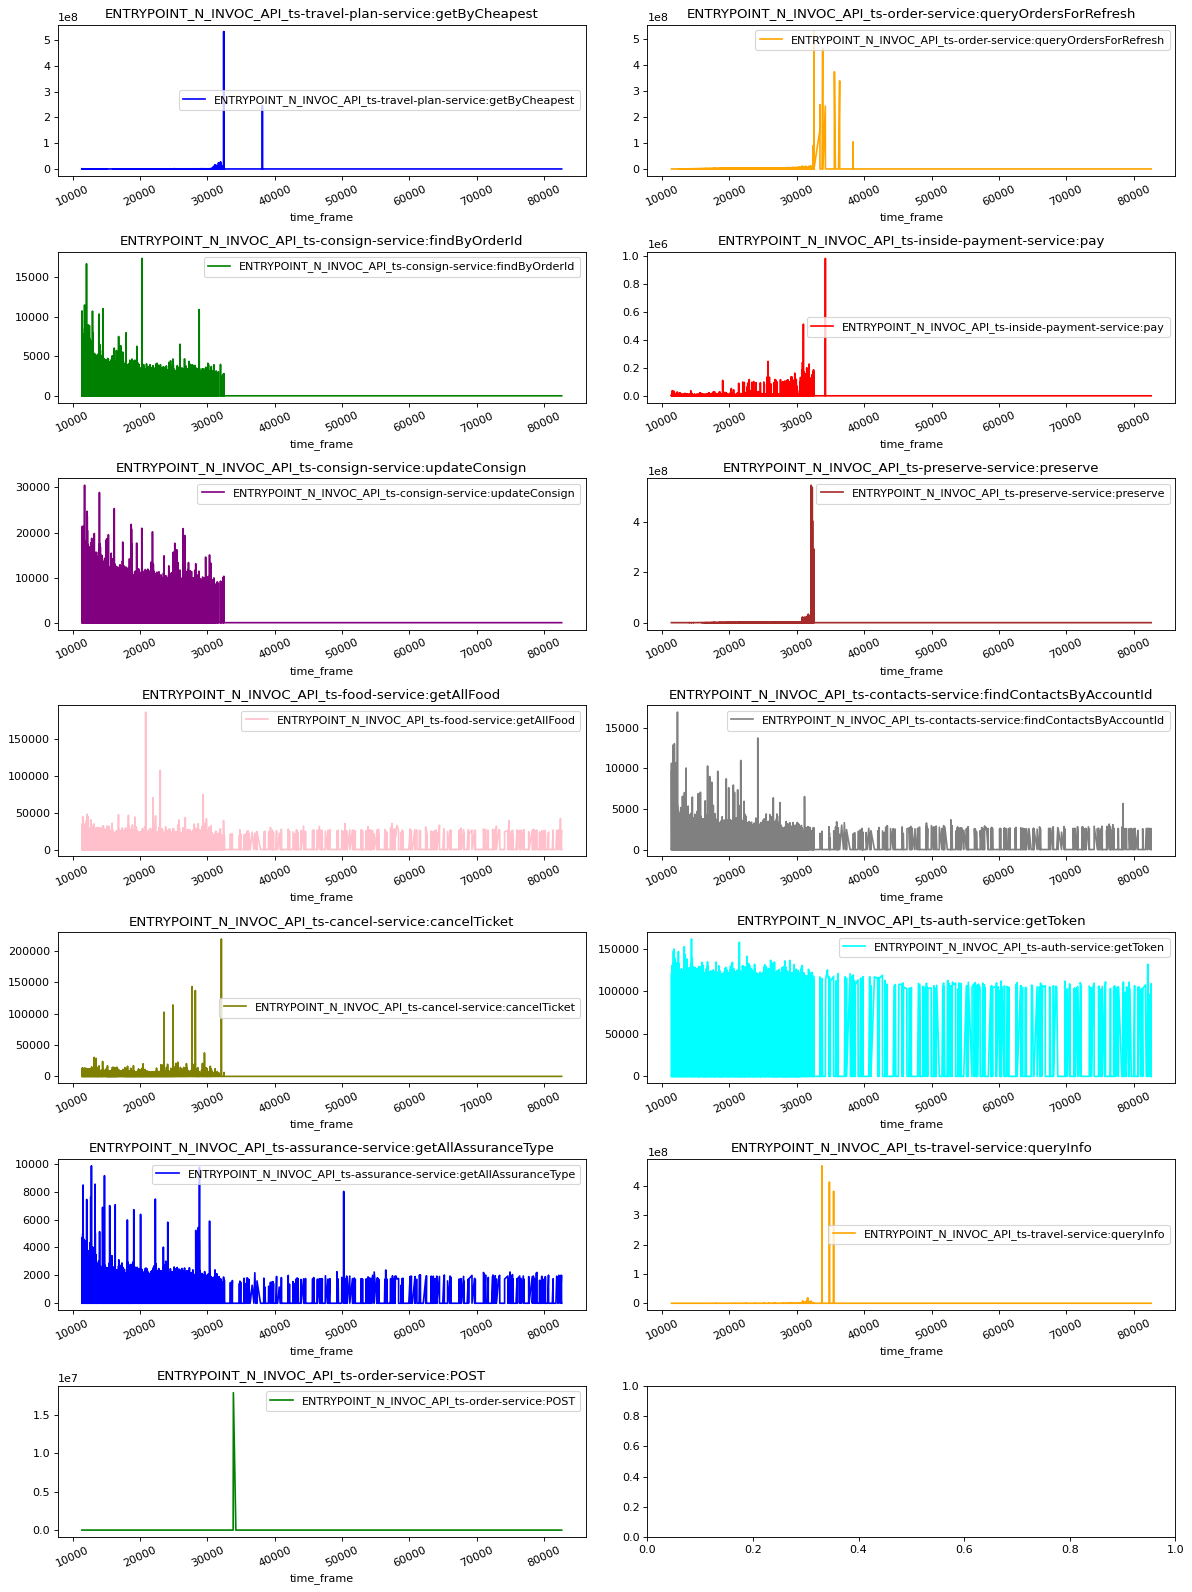

Data normalized
Input size 32 Output size 13
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 13)                429       
                                                                 
Total params: 4,621
Trainable params: 4,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
347/347 [==============================] - 1s 3ms/step - loss: 0.4092 - val_loss: 0.0056
Epoch 2/100
347/347 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 3/100
347/347 [==============================] - 1s 2ms/step - 

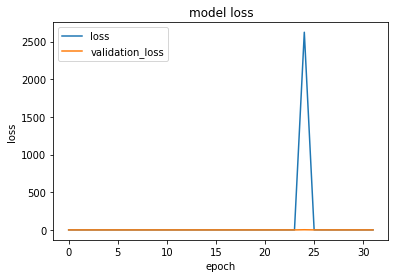

214/214 [==============================] - 0s 930us/step
TOTAL MSE:  0.014071099452746457
TOTAL MAE:  0.07709093533082467


====== Prediction for 0 ========


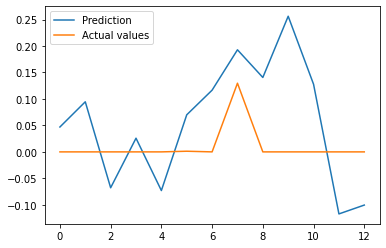



====== Prediction for 1 ========


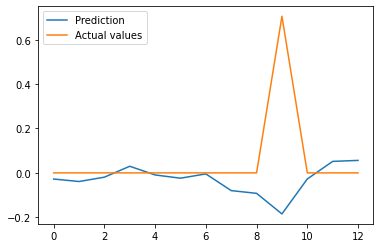



====== Prediction for 2 ========


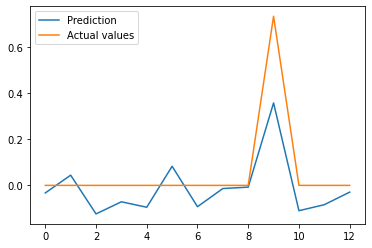



====== Prediction for 3 ========


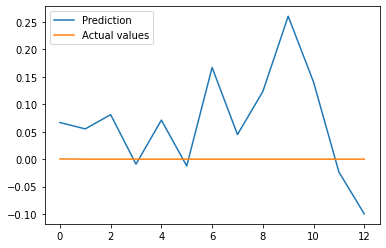



====== Prediction for 4 ========


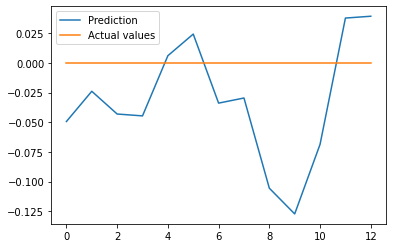



====== Prediction for 5 ========


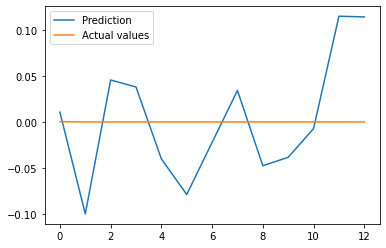



====== Prediction for 6 ========


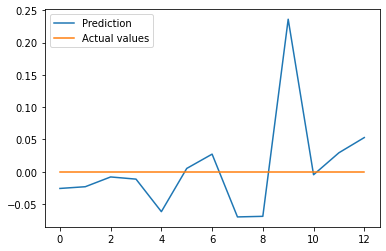



====== Prediction for 7 ========


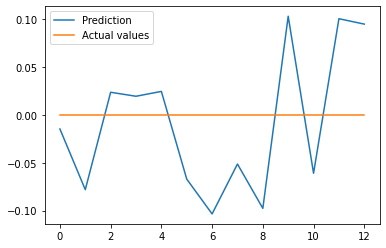



====== Prediction for 8 ========


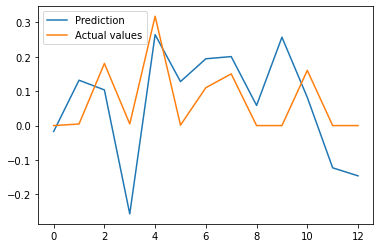



====== Prediction for 9 ========


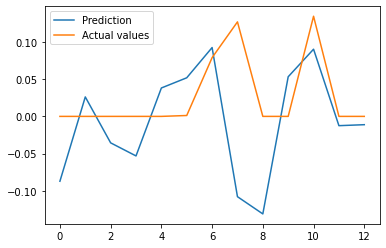



========= FEATURE 0 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest) ==========


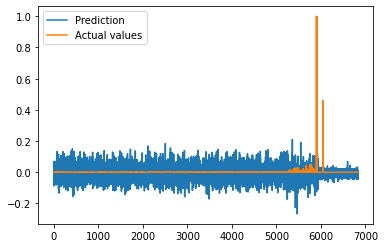

MAE:  0.034004465170041964
MSE:  0.002275448027244026


========= FEATURE 1 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh) ==========


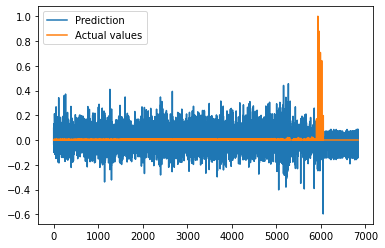

MAE:  0.06625389409792713
MSE:  0.007952404140113825


========= FEATURE 2 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId) ==========


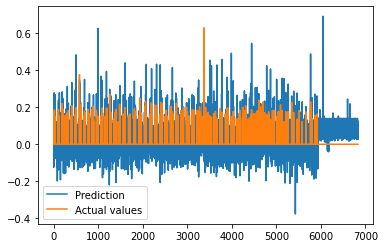

MAE:  0.05090546335751086
MSE:  0.004629484554332037


========= FEATURE 3 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay) ==========


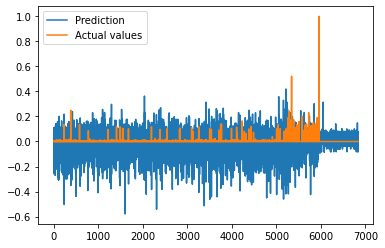

MAE:  0.06654279890670682
MSE:  0.008751453124688752


========= FEATURE 4 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign) ==========


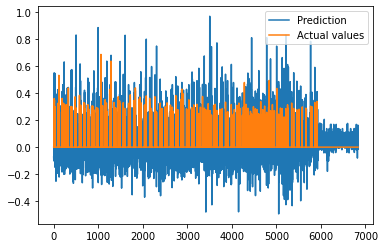

MAE:  0.08500038010761052
MSE:  0.013149319579722629


========= FEATURE 5 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve) ==========


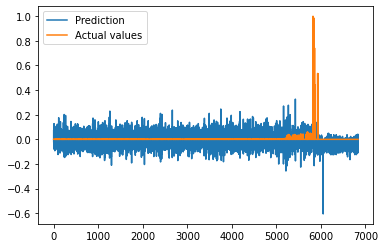

MAE:  0.043128924077371955
MSE:  0.003846606933213552


========= FEATURE 6 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood) ==========


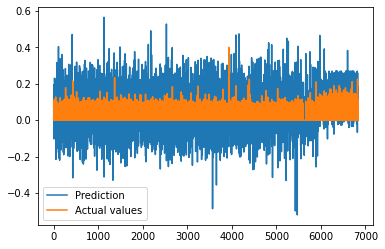

MAE:  0.0755708618328484
MSE:  0.009390975135793846


========= FEATURE 7 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId) ==========


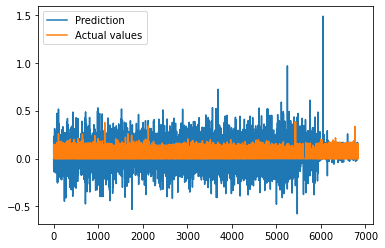

MAE:  0.10222875584440133
MSE:  0.01866200403463306


========= FEATURE 8 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket) ==========


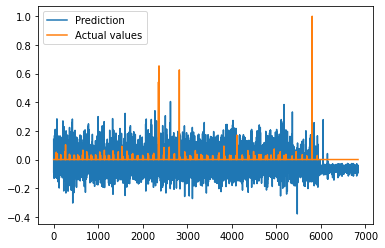

MAE:  0.06686829993693882
MSE:  0.006850881539086651


========= FEATURE 9 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken) ==========


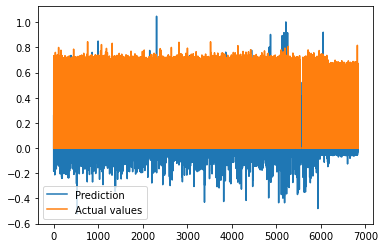

MAE:  0.19209230149012096
MSE:  0.08021187043878926


========= FEATURE 10 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType) ==========


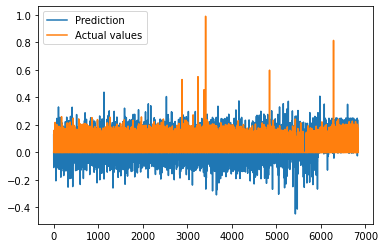

MAE:  0.06241660197794461
MSE:  0.006267862348924049


========= FEATURE 11 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo) ==========


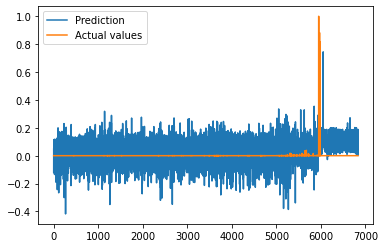

MAE:  0.07060007172872161
MSE:  0.007969139754664855


========= FEATURE 12 ANALYSIS (ENTRYPOINT_AVG_EXTIME_ts-order-service:POST) ==========


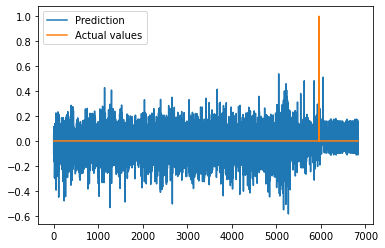

MAE:  0.08656934077257576
MSE:  0.012966843274499616


In [51]:
results["avv_dataset_DT_50.csv"] = MachineLearningAnalyzer("avv_dataset_DT_50.csv").perform_analysis()

In [52]:
pd.DataFrame.from_dict(results, orient="index")

,TOTAL MSE,TOTAL MAE,ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId MAE,ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId MSE,ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign MAE,ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign MSE,ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest MAE,ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest MSE,ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve MAE,ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve MSE,...,ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay MAE,ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay MSE,ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken MAE,ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken MSE,ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo MAE,ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo MSE,ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType MAE,ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType MSE,ENTRYPOINT_AVG_EXTIME_ts-order-service:POST MAE,ENTRYPOINT_AVG_EXTIME_ts-order-service:POST MSE
avv_dataset_DT_500.csv,0.019666,0.065498,0.028122,0.001483,0.043847,0.003152,0.019980,0.002990,0.023589,0.004258,...,0.012784,0.002270,0.377246,0.195778,0.021480,0.003423,0.095928,0.011881,0.009682,0.001287
avv_dataset_DT_100.csv,0.124611,0.254659,0.205752,0.078338,0.181590,0.059956,0.203690,0.075132,0.118875,0.033599,...,0.128830,0.038772,0.279470,0.113200,0.307719,0.175389,0.448011,0.266830,0.260892,0.118406
avv_dataset_DT_1000.csv,0.039275,0.091383,0.038606,0.001661,0.057949,0.003704,0.016030,0.004578,0.027452,0.006437,...,0.012868,0.002530,0.480812,0.383447,0.012916,0.004969,0.109397,0.013649,0.020719,0.002474
avv_dataset_DT_50.csv,0.014071,0.077091,0.050905,0.004629,0.085000,0.013149,0.034004,0.002275,0.043129,0.003847,...,0.066543,0.008751,0.192092,0.080212,0.070600,0.007969,0.062417,0.006268,0.086569,0.012967
